<a href="https://colab.research.google.com/github/Afix0/BP/blob/main/SDUEBA_002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
#Dependencies
import numpy as np
import pandas as pd
from collections import Counter
import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_text
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder

!pip install subgroups


In [40]:
#Parameters:
"""
vector_space_dimention  ... dimention of the embedding vector space
n_clusters              ... number of clusters to be found
max_depth               ... maximal depth of the decision tree
test_size               ... size of the test set for training the decision tree
mixed_threashold        ... threshold for classifying a cluster as mixed
"""


vector_space_dimention = 42
n_clusters = 15
max_depth = 4
test_size = 0.2
mixed_threashold = 0.7


In [41]:
from subgroups import datasets

dataset = datasets.load_car_evaluation_csv()
target = ('class', 'acc')

features_raw = pd.DataFrame(data=dataset[['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']])
target_df = pd.DataFrame(data=dataset[['class']])

# Display the first few rows
dataset.head()


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [42]:
#Data augemntation sentence creation
features_df = pd.DataFrame()
for column in features_raw.columns:
    split_columns = column.split("_")
    jointed_columns = ' '.join(split_columns)
    features_df[column] = features_raw[column].apply(lambda x: f"{jointed_columns} is {x}")

sentences = []
for i in range(len(features_df)):
    sentence = []
    for word in features_df.iloc[i]:
        sentence.append(word)
    sentences.append(sentence)

In [43]:
#Word2Vec training and clustering
def sentence_embedding(sentence, model):
    word_embeddings = []
    for word in sentence:
        word_embeddings.append(model.wv[word])
    return np.mean(word_embeddings, axis=0)

model = Word2Vec(sentences, min_count=1, vector_size=vector_space_dimention, window=5)
embeddings = np.array([sentence_embedding(sentence, model) for sentence in sentences])
labels_aglomerative_average = AgglomerativeClustering(n_clusters= n_clusters, metric = 'cosine', linkage='average').fit_predict(embeddings)

In [44]:
#Decission tree training
features_classify = features_raw.assign(cluster = labels_aglomerative_average)

encoder = OneHotEncoder()
X = features_classify.drop(columns=['cluster'])
X_encoded = encoder.fit_transform(X)
y = features_classify['cluster']
X_df = pd.DataFrame(X, columns=encoder.get_feature_names_out())


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=test_size, random_state=73, stratify=y)

clf = DecisionTreeClassifier(max_depth=max_depth, random_state=73)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.838150289017341
              precision    recall  f1-score   support

           0       0.70      1.00      0.83        19
           1       0.81      1.00      0.89        29
           2       1.00      0.90      0.95        30
           3       1.00      0.90      0.95        29
           4       1.00      0.97      0.98        29
           5       0.76      1.00      0.87        29
           6       1.00      0.90      0.95        29
           7       0.64      1.00      0.78        16
           8       0.71      1.00      0.83        29
           9       0.00      0.00      0.00         9
          10       0.78      1.00      0.88        29
          11       0.00      0.00      0.00        16
          12       0.00      0.00      0.00        16
          13       1.00      0.83      0.91        29
          14       0.73      1.00      0.84         8

    accuracy                           0.84       346
   macro avg       0.68      0.77      0.71       34

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
def classify_clusters(data_frame, target_df, mixed_threshold, cluster_labels, frequencies=False):

    cluster_to_class_counts = {}
    for i, label in enumerate(cluster_labels):
        cluster_to_class_counts.setdefault(label, {})
        class_label = target_df['class'][i]
        cluster_to_class_counts[label][class_label] = cluster_to_class_counts[label].get(class_label, 0) + 1

    cluster_classifications = {}
    cluster_frequencies = {}
    for cluster, class_counts in cluster_to_class_counts.items():
        total_count = sum(class_counts.values())
        dominant_class, dominant_count = max(class_counts.items(), key=lambda x: x[1])
        relative_frequency = dominant_count / total_count

        if relative_frequency >= mixed_threshold:
            cluster_classifications[cluster] = dominant_class
        else:
            cluster_classifications[cluster] = 'mixed'

        cluster_frequencies[cluster] = total_count

    if frequencies:
        return dict(sorted(cluster_classifications.items())), dict(sorted(cluster_frequencies.items()))
    else:
        return dict(sorted(cluster_classifications.items()))

classify_clusters(features_df, target_df, mixed_threashold, cluster_labels=labels_aglomerative_average, frequencies = True)

({0: 'unacc',
  1: 'mixed',
  2: 'unacc',
  3: 'mixed',
  4: 'mixed',
  5: 'mixed',
  6: 'unacc',
  7: 'mixed',
  8: 'mixed',
  9: 'mixed',
  10: 'mixed',
  11: 'mixed',
  12: 'mixed',
  13: 'unacc',
  14: 'unacc'},
 {0: 96,
  1: 144,
  2: 152,
  3: 144,
  4: 144,
  5: 144,
  6: 144,
  7: 80,
  8: 144,
  9: 48,
  10: 144,
  11: 80,
  12: 80,
  13: 144,
  14: 40})

In [46]:
def extract_rules(tree, feature_names, class_names, cluster_classifications, node=0, depth=0, rule=[], rules_list=None, unextractable_clusters=None):

    if rules_list is None:
        rules_list = []
    if unextractable_clusters is None:
        unextractable_clusters = []

    left_child = tree.tree_.children_left[node]
    right_child = tree.tree_.children_right[node]
    threshold = tree.tree_.threshold[node]
    feature = tree.tree_.feature[node]
    value = tree.tree_.value[node]

    if left_child == -1 and right_child == -1:
        class_label = class_names[value.argmax()]
        rules_list.append((class_label, " AND ".join(rule)))
        return rules_list, unextractable_clusters

    if left_child != -1:
        left_rule = rule + [f"{feature_names[feature]} <= {threshold:.2f}"]
        rules_list, unextractable_clusters = extract_rules(tree, feature_names, class_names, cluster_classifications, left_child, depth + 1, left_rule, rules_list, unextractable_clusters)

    if right_child != -1:
        right_rule = rule + [f"{feature_names[feature]} > {threshold:.2f}"]
        rules_list, unextractable_clusters = extract_rules(tree, feature_names, class_names, cluster_classifications, right_child, depth + 1, right_rule, rules_list, unextractable_clusters)

    if depth == 0:
        sorted_rules = sorted(rules_list, key=lambda x: x[0])
        print("Rules for subgroups:")
        extracted_clusters = set()

        for class_label, rule_text in sorted_rules:
            extracted_clusters.add(class_label)
            print(f"Rule for subgroup '{class_label}' ({cluster_classifications[class_label]}): {rule_text}")

        for cluster, classification in cluster_classifications.items():
            if cluster not in extracted_clusters:
                unextractable_clusters.append(cluster)

    return rules_list, unextractable_clusters

rules, unextractable_clusters = extract_rules(clf, list(X_df.columns), list(set(features_classify['cluster'])), cluster_classifications=classify_clusters(features_df, target_df, mixed_threashold, cluster_labels=labels_aglomerative_average))
print(f"Unextractable clusters: {unextractable_clusters}")

Rules for subgroups:
Rule for subgroup '0' (unacc): persons_2 > 0.50 AND lug_boot_med <= 0.50 AND lug_boot_big <= 0.50 AND safety_med > 0.50
Rule for subgroup '0' (unacc): persons_2 > 0.50 AND lug_boot_med <= 0.50 AND lug_boot_big > 0.50 AND safety_med > 0.50
Rule for subgroup '1' (mixed): persons_2 <= 0.50 AND lug_boot_med <= 0.50 AND lug_boot_small > 0.50 AND persons_more <= 0.50
Rule for subgroup '2' (unacc): persons_2 > 0.50 AND lug_boot_med > 0.50 AND safety_med <= 0.50
Rule for subgroup '2' (unacc): persons_2 > 0.50 AND lug_boot_med > 0.50 AND safety_med > 0.50 AND doors_5more > 0.50
Rule for subgroup '3' (mixed): persons_2 <= 0.50 AND lug_boot_med > 0.50 AND persons_more <= 0.50 AND safety_med <= 0.50
Rule for subgroup '4' (mixed): persons_2 <= 0.50 AND lug_boot_med > 0.50 AND persons_more > 0.50 AND safety_med <= 0.50
Rule for subgroup '5' (mixed): persons_2 <= 0.50 AND lug_boot_med <= 0.50 AND lug_boot_small <= 0.50 AND persons_more > 0.50
Rule for subgroup '6' (unacc): person

In [47]:
#Cluster metrics
def calculate_support(data_frame, target_df, mixed_threshold, cluster_labels):

    classifications, frequencies = classify_clusters(data_frame, target_df, mixed_threshold, cluster_labels, frequencies=True)

    total_targets = len(cluster_labels)

    support = sum(freq for cluster, freq in frequencies.items() if cluster not in unextractable_clusters)

    support_percentage = (support / total_targets) * 100
    return support_percentage

support = calculate_support(features_df, target_df, mixed_threashold, cluster_labels=labels_aglomerative_average)
print(f"Overall support of describable subgroups is {support:.2f}%") #Subgroups can be undescribable if they are too small and decission tree cant find the rules for characterization
#Entropy, serendipity TBD - dont know how to do it at the moment

Overall support of describable subgroups is 87.96%


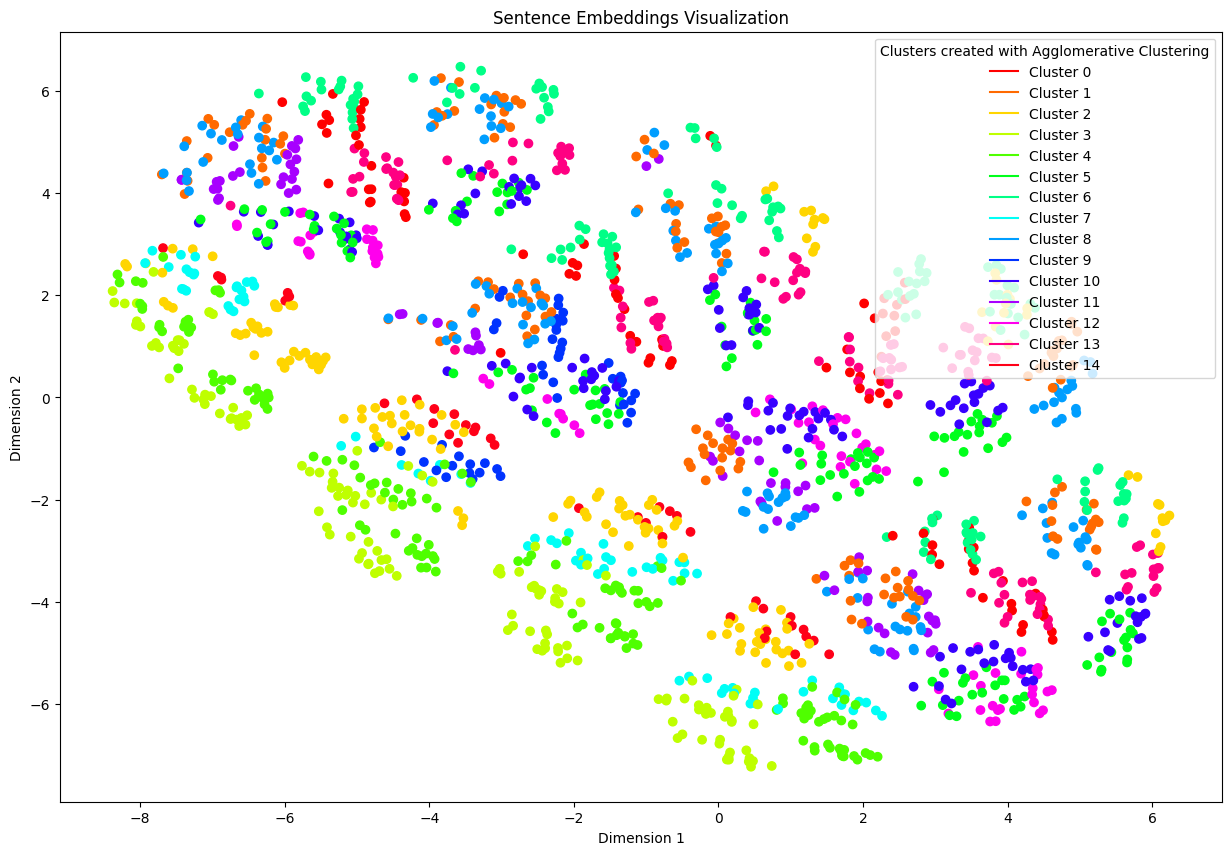

In [48]:
#Clusters visualization
def plot_sentence_embeddings(embeddings, cluster_labels=None, target_labels=None, clustering_method=None):
    plt.figure(figsize=(15, 10))
    tsne = TSNE(n_components=2, random_state= 73, perplexity=300, learning_rate=200, max_iter=1000)
    embeddings_2d = tsne.fit_transform(np.array(embeddings))
    cmap = plt.colormaps['hsv']


    if cluster_labels is not None and target_labels is None:
        n_clusters = len(set(cluster_labels))
        colors = cmap(np.linspace(0, 1, n_clusters))
        handles = [plt.Line2D([], [], color=color) for color in colors]
        labels = [f"Cluster {i}" for i in range(n_clusters)]
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors[cluster_labels])

        plt.legend(handles=handles, labels=labels, title=f"Clusters created with {clustering_method}", loc = "upper right")

    elif target_labels is not None and cluster_labels is None:

        edible_color = 'green'
        poisonous_color = 'red'

        colors = [edible_color if label == 'edible' else poisonous_color for label in target_labels]

        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)
        handles = [plt.Line2D([], [], color=edible_color, label='Edible'), plt.Line2D([], [], color=poisonous_color, label='Poisonous')]

        labels = ['Edible', 'Poisonous']

        plt.legend(handles=handles, labels=labels, title="Classes", loc="upper right")


    else:
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=range(len(sentences)), cmap=cmap)

    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title(f"Sentence Embeddings Visualization")
plot_sentence_embeddings(embeddings, cluster_labels=labels_aglomerative_average, clustering_method='Agglomerative Clustering')

In [49]:
from subgroups.quality_measures import WRAcc
from subgroups.quality_measures import WRAccOptimisticEstimate1
from subgroups.algorithms import VLSD

# First, we execute the VLSD algorithm to mine the inicial collection of candidates.
vlsd_model = VLSD(quality_measure = WRAcc(), q_minimum_threshold  = -1, optimistic_estimate = WRAccOptimisticEstimate1(), oe_minimum_threshold = -1, sort_criterion_in_s1 = VLSD.SORT_CRITERION_NO_ORDER, sort_criterion_in_other_sizes = VLSD.SORT_CRITERION_NO_ORDER, vertical_lists_implementation = VLSD.VERTICAL_LISTS_WITH_BITSETS, write_results_in_file = True, file_path = "./vlsd_result.txt")
vlsd_model.fit(dataset, target)

In [50]:
# The resulting file generated by the VLSD algorithm contains a lot of information (it is more verbose).
# However, the input file of the DSLM algorithm need to have a specific format.
# This means that we have to make a transformation.
from subgroups.utils.file_format_transformations import to_input_format_for_subgroup_list_algorithms

subgroups_correctly_read, subgroups_not_correctly_read = to_input_format_for_subgroup_list_algorithms("./vlsd_result.txt", "./vlsd_result_transformed.txt")
print("Subgroups correctly read: " + str(subgroups_correctly_read))
print("Subgroups not correctly read: " + str(subgroups_not_correctly_read))

Subgroups correctly read: 7999
Subgroups not correctly read: 0


In [51]:
from subgroups.algorithms import DSLM

# Now, we execute the DSLM algorithm to mine diverse top-k subgroup lists.
dslm_model = DSLM(input_file_path = "./vlsd_result_transformed.txt",
                  max_sl = 3,
                  sl_max_size = 10,
                  beta = 0.0,
                  maximum_positive_overlap = 0.06,
                  maximum_negative_overlap = 0.06,
                  output_file_path = "dslm_result.txt")
dslm_model.fit(dataset, target)

In [52]:
file = open("./dslm_result.txt", "r")
print(file.read())
file.close()

Dataset information:
	- Number of instances: 1728.
	- Number of positive instances: 384.
	- Number of negative instances: 1344.
	- Total number of attributes (including the target): 7.


Reading input file.
Read subgroups: 7999.
Input file read.


## Subgroup list (4 subgroups) ##
s1: Description: [persons = '4', safety = 'high'], Target: class = 'acc'
	Considering its position in the list:
	- positive instances covered: 108
	- negative instances covered: 84
	- total instances covered: 192
	Considering it individually:
	- positive instances covered: 108
	- negative instances covered: 84
	- total instances covered: 192
s2: Description: [persons = 'more', safety = 'high'], Target: class = 'acc'
	Considering its position in the list:
	- positive instances covered: 96
	- negative instances covered: 96
	- total instances covered: 192
	Considering it individually:
	- positive instances covered: 96
	- negative instances covered: 96
	- total instances covered: 192
s3: Description: [persons = '